In [1]:
import numpy as np

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [2]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box)
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`:

        output = module.forward(input)

    The module should be able to perform a backward pass: to differentiate the `forward` function.
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule.

        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.

        This includes
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput


    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.

        Make sure to both store the data in `output` field and return it.
        """

        # The easiest case:

        # self.output = input
        # return self.output

        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input.
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.

        The shape of `gradInput` is always the same as the shape of `input`.

        Make sure to both store the gradients in `gradInput` field and return it.
        """

        # The easiest case:

        # self.gradInput = gradOutput
        # return self.gradInput

        pass

    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass

    def zeroGradParameters(self):
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass

    def getParameters(self):
        """
        Returns a list with its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters.
        If the module does not have parameters return empty list.
        """
        return []

    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True

    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Module"

# Sequential container

**Define** a forward and backward pass procedures.

In [3]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially.

         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`.
    """

    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:

            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})


        Just write a little loop.
        """

        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output) #Your code goes here. ################################################
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:

            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)
            gradInput = module[0].backward(input, g_1)


        !!!

        To ech module you need to provide the input, module saw while forward pass,
        it is used while computing gradients.
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass)
        and NOT `input` to this Sequential module.

        !!!

        """
        # не надо Your code goes here. ################################################
        modules_inputs = [input] + [module.output for module in self.modules[:-1]]
        self.gradInput = gradOutput
        for module, module_input in zip(self.modules[::-1], modules_inputs[::-1]):
            self.gradInput = module.backward(module_input, self.gradInput)

        return self.gradInput


    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]

    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]

    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string

    def __getitem__(self,x):
        return self.modules.__getitem__(x)

    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [4]:
#еализовать линейный слой
class Linear(Module):
    """
    A module which applies a linear transformation
    A common name is fully-connected layer, InnerProductLayer in caffe.

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input.dot(self.W.T) + self.b
        return self.output   #прямой проход

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput.dot(self.W)
        return self.gradInput #обратный проход

    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW = gradOutput.T.dot(input) ; self.gradb = gradOutput.sum(axis=0)
        pass

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb] #-------------------------

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [5]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()

    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        np.exp(self.output, out=self.output)
        np.divide(self.output, self.output.sum(axis=1, keepdims=True), out=self.output)################################################
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.output
        np.subtract(self.gradInput, self.output * self.gradInput.sum(axis=1, keepdims=True), out=self.gradInput)
        ################################################
        return self.gradInput

    def __repr__(self):
        return "SoftMax"

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [6]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        np.subtract(self.output, np.log(np.exp(self.output).sum(axis=1, keepdims=True)), out=self.output)
        ################################################
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput - np.exp(self.output) * np.sum(gradOutput, axis=1, keepdims=True)
        ################################################
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax"

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [7]:
class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None

    def updateMeanVariance(self, batch_mean, batch_variance):
        self.moving_mean = batch_mean if self.moving_mean is None else self.moving_mean
        self.moving_variance = batch_variance if self.moving_variance is None else self.moving_variance

        np.multiply(self.moving_mean, self.alpha, out=self.moving_mean)
        np.multiply(batch_mean, 1-self.alpha, out=batch_mean)
        np.add(self.moving_mean, batch_mean, out=self.moving_mean)
        np.multiply(self.moving_variance, self.alpha, out=self.moving_variance)
        np.multiply(batch_variance, 1-self.alpha, out=batch_variance)
        np.add(self.moving_variance, batch_variance, out=self.moving_variance)

    def updateOutput(self, input):
        batch_mean = np.mean(input, axis=0) if self.training else self.moving_mean
        batch_variance = np.var(input, axis=0) if self.training else self.moving_variance

        self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
        if self.training:
            self.updateMeanVariance(batch_mean, batch_variance)
        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_mean = np.mean(input, axis=0) if self.training else self.moving_mean
        batch_variance = np.var(input, axis=0) if self.training else self.moving_variance
        m = input.shape[0]

        variable0 = input - batch_mean
        variable1 = np.sum(gradOutput * variable0, axis=0)
        variable2 = np.sum(gradOutput, axis=0)
        variable3 = np.sqrt(batch_variance + self.EPS)

        self.gradInput = gradOutput / variable3
        self.gradInput -= variable1 * variable0 / m / variable3 / (batch_variance + self.EPS)
        self.gradInput -= variable2 / m / variable3
        self.gradInput += variable1 * np.sum(variable0, 0) / m**2 / variable3**(3/2)

        return self.gradInput

    def __repr__(self):
        return "BatchNormalization"


In [8]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return "ChannelwiseScaling"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [9]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()

        self.p = p
        self.mask = None #,p

    def updateOutput(self, input):
        # Your code goes here. ################################################
        if not self.training:
            self.output = input
            return self.output
        self.mask = np.random.choice(2, input.shape, p=[self.p, (1.0 - self.p)])
        self.output = np.multiply(input, self.mask) / (1 - self.p)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = np.multiply(gradOutput, self.mask) / (1 - self.p)
        return self.gradInput

    def __repr__(self):
        return "Dropout"

#6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [12]:
class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, bias=True, padding_mode='zeros'):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.padding = padding
        self.bias_flag = bias
        self.padding_mode = 'edge' if padding_mode == 'replicate' else padding_mode
        if self.padding_mode not in ['zeros', 'edge', 'reflect']:
            self.padding_mode = 'zeros'

        self.kH, self.kW = self.kernel_size
        self.sH, self.sW = self.stride

        self.weights = np.random.randn(out_channels, in_channels, self.kH, self.kW) * 0.01
        self.biases = np.random.randn(out_channels) * 0.01 if self.bias_flag else None

    def updateOutput(self, input):
        batch_size, _, height, width = input.shape
        kH, kW = self.kH, self.kW
        sH, sW = self.sH, self.sW

        if isinstance(self.padding, str) and self.padding.lower() == 'same':
            out_height = int(np.ceil(height / sH))
            out_width = int(np.ceil(width / sW))
            total_pad_h = max(0, (out_height - 1) * sH + kH - height)
            total_pad_w = max(0, (out_width - 1) * sW + kW - width)
            pH_left, pH_right = total_pad_h // 2, total_pad_h - total_pad_h // 2
            pW_left, pW_right = total_pad_w // 2, total_pad_w - total_pad_w // 2
        else:
            if isinstance(self.padding, int):
                pH_left = pH_right = pW_left = pW_right = self.padding
            else:
                pH_left, pW_left = self.padding
                pH_right, pW_right = pH_left, pW_left
            out_height = (height + pH_left + pH_right - kH) // sH + 1
            out_width = (width + pW_left + pW_right - kW) // sW + 1

        if pH_left > 0 or pH_right > 0 or pW_left > 0 or pW_right > 0:
          if self.padding_mode == 'zeros':
              input_padded = np.pad(input, ((0, 0), (0, 0), (pH_left, pH_right), (pW_left, pW_right)),
                                  mode='constant', constant_values=0)
          else:
              input_padded = np.pad(input, ((0, 0), (0, 0), (pH_left, pH_right), (pW_left, pW_right)),
                                  mode=self.padding_mode)
        else:
          input_padded = input

        self.output = np.zeros((batch_size, self.out_channels, out_height, out_width))

        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start, w_start = i * sH, j * sW
                        h_end, w_end = h_start + kH, w_start + kW
                        region = input_padded[b, :, h_start:h_end, w_start:w_end]
                        self.output[b, oc, i, j] = np.sum(region * self.weights[oc])
                        if self.bias_flag:
                            self.output[b, oc, i, j] += self.biases[oc]

        return self.output

    def __repr__(self):
        return f"Conv2d({self.in_channels}, {self.out_channels}, kernel_size={self.kernel_size}, stride={self.stride}, padding={self.padding})"

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [13]:
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride, padding):
        super(MaxPool2d, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def updateOutput(self, input):
        batch_size, channels, height, width = input.shape
        k = self.kernel_size
        s = self.stride
        p = self.padding

        out_height = (height + 2 * p - k) // s + 1
        out_width = (width + 2 * p - k) // s + 1

        padded_input = np.pad(input, ((0, 0), (0, 0), (p, p), (p, p)), mode='constant', constant_values=0)

        self.output = np.zeros((batch_size, channels, out_height, out_width))
        self.max_mask = np.zeros_like(padded_input)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * s
                        h_end = h_start + k
                        w_start = j * s
                        w_end = w_start + k

                        window = padded_input[b, c, h_start:h_end, w_start:w_end]
                        self.output[b, c, i, j] = np.max(window)
                        self.max_mask[b, c, h_start:h_end, w_start:w_end] = (window == np.max(window))

        return self.output

    def updateGradInput(self, input, gradOutput):
        batch_size, channels, height, width = input.shape
        k = self.kernel_size
        s = self.stride
        p = self.padding

        padded_gradInput = np.zeros((batch_size, channels, height + 2 * p, width + 2 * p))

        out_height, out_width = gradOutput.shape[2], gradOutput.shape[3]

        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * s
                        h_end = h_start + k
                        w_start = j * s
                        w_end = w_start + k

                        window = input[b, c, h_start:h_end, w_start:w_end]
                        max_value = np.max(window)
                        max_mask = (window == max_value)

                        padded_gradInput[b, c, h_start:h_end, w_start:w_end] += (
                            max_mask * gradOutput[b, c, i, j]
                        )

        if self.padding > 0:
            self.gradInput = padded_gradInput[:, :, p:-p, p:-p]
        else:
            self.gradInput = padded_gradInput

        return self.gradInput

    def __repr__(self):
        return "MaxPool2d"




#8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.




#9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [14]:
class Flatten(Module): #то как меняем размерность входящего тензора
    def __init__(self, start_dim=0, end_dim=-1):
        super(Flatten, self).__init__()

        self.start_dim = start_dim
        self.end_dim = end_dim

    def updateOutput(self, input):
        shape = input.shape
        start_dim = self.start_dim
        end_dim = self.end_dim if self.end_dim >= 0 else len(shape) + self.end_dim
        new_shape = shape[:start_dim] + (-1,) + shape[end_dim + 1:]
        self.output = input.reshape(new_shape)
        #self.output = input.reshape(input.shape[0], -1)# Your code goes here. ################################################
        return  self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)# Your code goes here. ################################################
        return self.gradInput

    def __repr__(self):
        return "Flatten"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [15]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput , input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU"

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [16]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()

        self.slope = slope

    def updateOutput(self, input):
        self.output = np.maximum(input, input * self.slope)#################################################
        return  self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, self.slope * gradOutput) #############################################
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [17]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()

        self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input > 0, input, self.alpha * (np.exp(input) - 1.))  ################################################
        return  self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, self.alpha * np.exp(input) * gradOutput)################################################
        return self.gradInput

    def __repr__(self):
        return "ELU"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [18]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        self.output = np.log(np.exp(input) + 1.)################################################
        return  self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * (1 / (1 + np.exp(-input))) ################################################
        return self.gradInput

    def __repr__(self):
        return "SoftPlus"

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [19]:
from scipy.special import erf

class Gelu(Module):
    def __init__(self):
        super(Gelu, self).__init__()

    def updateOutput(self, input):
        self.output = 0.5 * input * (1 + erf(input / np.sqrt(2)))
        return self.output

    def updateGradInput(self, input, gradOutput):
        sqrt2pi_inv = 1 / np.sqrt(2 * np.pi)
        grad_gelu = 0.5 * (1 + erf(input / np.sqrt(2))) + input * sqrt2pi_inv * np.exp(-0.5 * input**2)
        self.gradInput = gradOutput * grad_gelu
        return self.gradInput

    def __repr__(self):
        return "Gelu"

# Criterions

Criterions are used to score the models answers.

In [20]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None

    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result.

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want
        to have readable description.
        """
        return "Criterion"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [21]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [22]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        self.output = -np.sum(target * np.log(input_clamp)) / input.shape[0]################################################
        return self.output

    def updateGradInput(self, input, target):
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)

        self.gradInput = -target / input_clamp / input.shape[0]################################################
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable"

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [23]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        self.output = -np.sum(target * input) / input.shape[0]################################################
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = -target / input.shape[0]################################################
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterion"

1-я часть задания: реализация слоев, лосей и функций активации - 5 баллов. \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами. - 1 балл.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель. - 1 балл.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы - 1 балла.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд. - 2 балла. \\

Дополнительно в оценке каждой модели будет учитываться:
1. Наличие правильно выбранной метрики и лосс функции.
2. Отрисовка графиков лосей и метрик на трейне-валидации. Проверка качества модели на тесте.
3. Наличие шедулера для lr.
4. Наличие вормапа.
5. Наличие механизма ранней остановки и сохранение лучшей модели.
6. Свитч лося (метрики) и оптимайзера.

# 1 задание

In [24]:
class Adam:
    def __init__(self, modules, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):

        self.modules = modules
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = {}
        self.v = {}
        self.t = 0

    def step(self):
        self.t += 1
        for module in self.modules:
            params = module.getParameters()
            grad_params = module.getGradParameters()
            for i, (param, grad) in enumerate(zip(params, grad_params)):
                param_id = id(param)

                if param_id not in self.m:
                    self.m[param_id] = np.zeros_like(param)
                    self.v[param_id] = np.zeros_like(param)

                self.m[param_id] = self.beta1 * self.m[param_id] + (1 - self.beta1) * grad
                self.v[param_id] = self.beta2 * self.v[param_id] + (1 - self.beta2) * grad**2

                m_hat = self.m[param_id] / (1 - self.beta1**self.t)
                v_hat = self.v[param_id] / (1 - self.beta2**self.t)

                param -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for module in self.modules:
            module.zeroGradParameters()

Epoch 10/60, Loss: 66.61559456993974
Epoch 20/60, Loss: 24.80567635608244
Epoch 30/60, Loss: 6.140633122914764
Epoch 40/60, Loss: 1.3303913841979595
Epoch 50/60, Loss: 0.740699879824029
Epoch 60/60, Loss: 0.6455299694186175


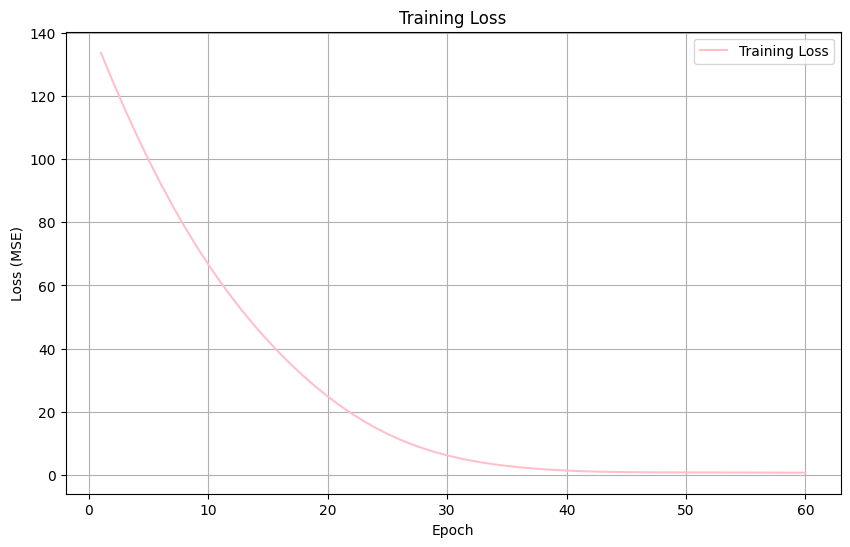

In [25]:
import matplotlib.pyplot as plt

model = Sequential()
model.add(Linear(5, 3))

optimizer = Adam(model.modules, lr=0.01)

X = np.array([[1, 2, 3, 4, 5],
              [2, 3, 4, 5, 6],
              [5, 6, 7, 8, 9]])
y = np.array([[1, 0, 2],
              [2, 1, 3],
              [3, 2, 4]])

criterion = MSECriterion()
train_losses = []

epochs = 60
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model.forward(X)
    loss = criterion.forward(output, y)
    grad = criterion.backward(output, y)
    model.backward(X, grad)
    optimizer.step()
    train_losses.append(loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.show()

# 2 задание

## маленькая модель

In [26]:
small_model = Sequential()
small_model.add(Linear(8, 10))
small_model.add(BatchNormalization())
small_model.add(ReLU())
small_model.add(Dropout(0.3))
small_model.add(Linear(10, 2))

## средняя модель

In [27]:
medium_model = Sequential()
medium_model.add(Linear(8, 32))
medium_model.add(BatchNormalization())
medium_model.add(ReLU())
medium_model.add(Dropout(0.5))
medium_model.add(Linear(32, 16))
medium_model.add(BatchNormalization())
medium_model.add(ReLU())
medium_model.add(Dropout(0.3))
medium_model.add(Linear(16, 2))

## большая модель

In [28]:
large_model = Sequential()
large_model.add(Linear(8, 64))
large_model.add(BatchNormalization())
large_model.add(ReLU())
large_model.add(Dropout(0.5))
large_model.add(Linear(64, 32))
large_model.add(BatchNormalization())
large_model.add(ReLU())
large_model.add(Dropout(0.4))
large_model.add(Linear(32, 16))
large_model.add(BatchNormalization())
large_model.add(ReLU())
large_model.add(Dropout(0.3))
large_model.add(Linear(16, 2))

Correlation matrix of y_train:
[[1.         0.51018457 0.31658137]
 [0.51018457 1.         0.40751775]
 [0.31658137 0.40751775 1.        ]]

Training Small model (112 parameters)
  With ReLU
Initial Train Loss: 3.4807870673635377
  With LeakyReLU
Initial Train Loss: 3.7404233674553886
  With Gelu
Initial Train Loss: 3.6143716943618625

Training Medium model (850 parameters)
  With ReLU
Initial Train Loss: 3.853112768918789
  With LeakyReLU
Initial Train Loss: 3.7255285199451738
  With Gelu
Initial Train Loss: 3.763924463147136

Training Large model (3218 parameters)
  With ReLU
Initial Train Loss: 3.6329873931584324
  With LeakyReLU
Initial Train Loss: 3.904898503540489
  With Gelu
Initial Train Loss: 3.4992620708720423


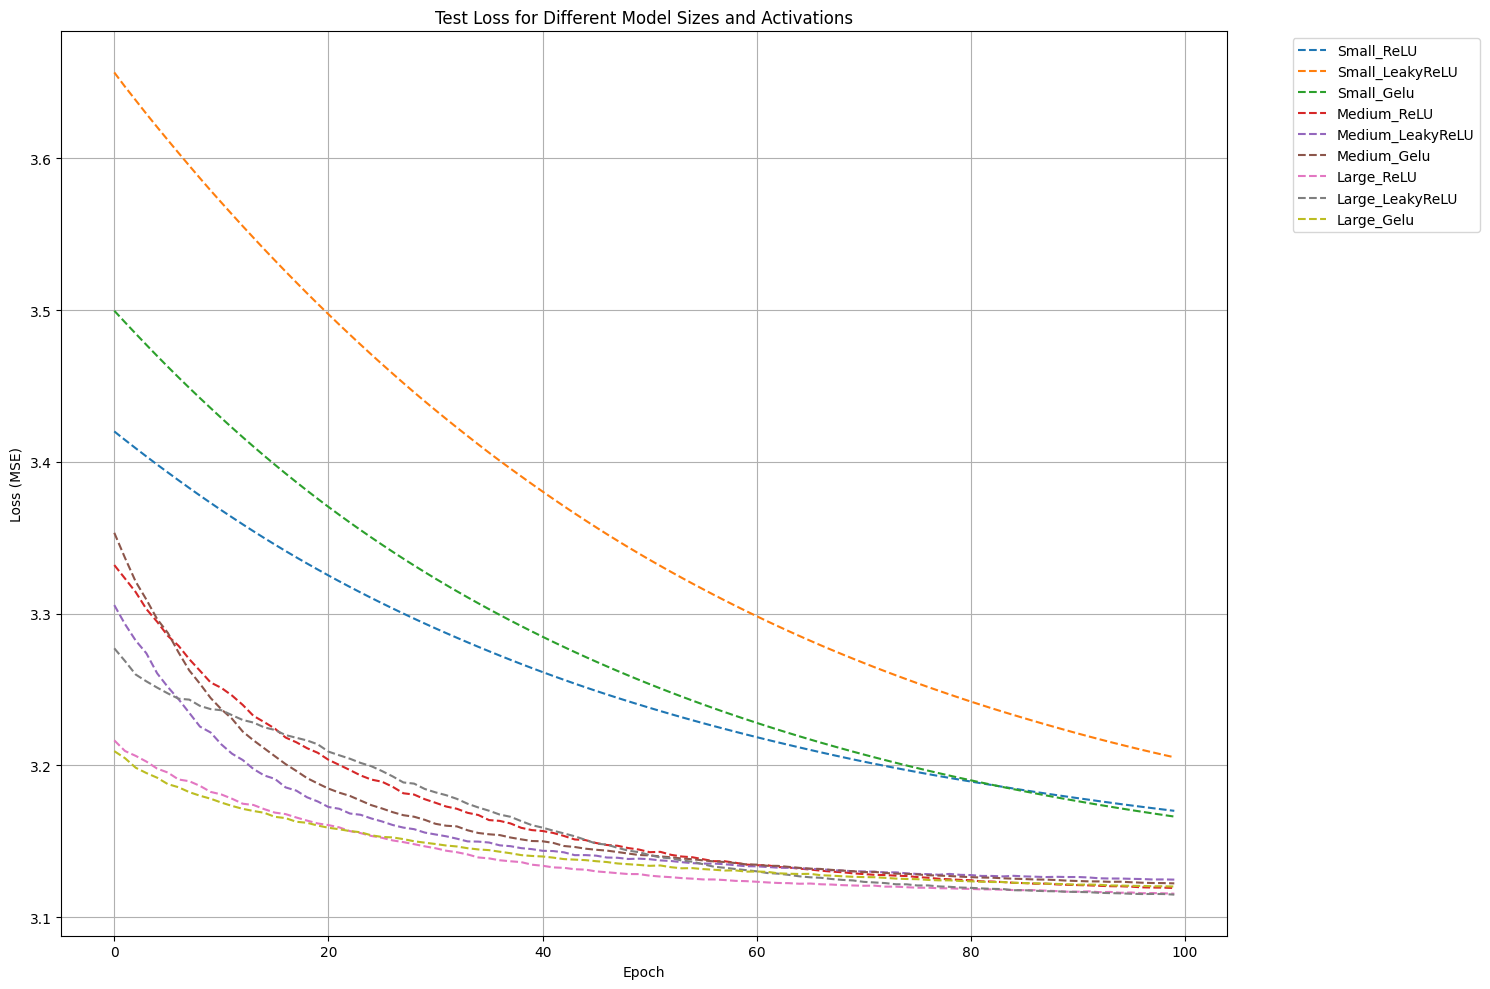


Best model: Large_LeakyReLU with Test MSE: 3.1157


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

n_samples = 20000
n_features = 5
n_outputs = 3

A = np.array([[0.5, 0.1, 0.2, 0.05, 0.1],
              [0.2, 0.4, 0.1, 0.15, 0.05],
              [0.1, 0.2, 0.3, 0.1, 0.2]])

cov = np.array([[1.0, 0.5, 0.3],
                [0.5, 1.0, 0.4],
                [0.3, 0.4, 1.0]])

noise = np.random.multivariate_normal(mean=[0, 0, 0], cov=cov, size=n_samples)

X = np.zeros((n_samples, n_features))
y = np.zeros((n_samples, n_outputs))

for t in range(1, n_samples):
    X[t] = np.random.randn(n_features) * 0.1 + X[t-1] * 0.8
    y[t] = X[t] @ A.T + noise[t]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Correlation matrix of y_train:")
print(np.corrcoef(y_train.T))

def count_parameters(model):
    total_params = 0
    for module in model.modules:
        if hasattr(module, 'W'):
            total_params += module.W.size + module.b.size
    return total_params

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.001):
    criterion = MSECriterion()
    optimizer = Adam(model.modules, lr=lr)
    train_losses = []
    test_losses = []

    # model = Sequential()
    model.evaluate()
    model.train()
    initial_output = model.forward(X_train)
    initial_loss = criterion.forward(initial_output, y_train)
    print(f"Initial Train Loss: {initial_loss}")

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model.forward(X_train)
        loss = criterion.forward(output, y_train)
        grad = criterion.backward(output, y_train)
        model.backward(X_train, grad)
        optimizer.step()
        train_losses.append(loss)

        model.evaluate()
        test_output = model.forward(X_test)
        test_loss = criterion.forward(test_output, y_test)
        test_losses.append(test_loss)

    return train_losses, test_losses

models = {
    "Small": small_model,
    "Medium": medium_model,
    "Large": large_model
}

activations = {
    "ReLU": ReLU(),
    "LeakyReLU": LeakyReLU(slope=0.1),
    "Gelu": Gelu()
}

results = {}
best_model = None
best_mse = float('inf')
best_model_name = ""

for size, base_model in models.items():
    print(f"\nTraining {size} model ({count_parameters(base_model)} parameters)")
    for act_name, activation in activations.items():
        if size == "Small":
            model = Sequential()
            model.add(Linear(5, 8))
            model.add(BatchNormalization())
            model.add(activation)
            model.add(Dropout(0.3))
            model.add(Linear(8, 3))
        elif size == "Medium":
            model = Sequential()
            model.add(Linear(5, 32))
            model.add(BatchNormalization())
            model.add(activation)
            model.add(Dropout(0.5))
            model.add(Linear(32, 16))
            model.add(BatchNormalization())
            model.add(activation)
            model.add(Dropout(0.3))
            model.add(Linear(16, 3))
        else:  # Large
            model = Sequential()
            model.add(Linear(5, 64))
            model.add(BatchNormalization())
            model.add(activation)
            model.add(Dropout(0.5))
            model.add(Linear(64, 32))
            model.add(BatchNormalization())
            model.add(activation)
            model.add(Dropout(0.4))
            model.add(Linear(32, 16))
            model.add(BatchNormalization())
            model.add(activation)
            model.add(Dropout(0.3))
            model.add(Linear(16, 3))

        print(f"  With {act_name}")
        train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)
        results[f"{size}_{act_name}"] = (train_losses, test_losses)

        final_mse = np.mean(test_losses[-10:])
        if final_mse < best_mse:
            best_mse = final_mse
            best_model_name = f"{size}_{act_name}"
            best_model = model

plt.figure(figsize=(15, 10))
for key, (train_losses, test_losses) in results.items():
    plt.plot(test_losses, linestyle='--', label=f"{key}")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Test Loss for Different Model Sizes and Activations')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nBest model: {best_model_name} with Test MSE: {best_mse:.4f}")

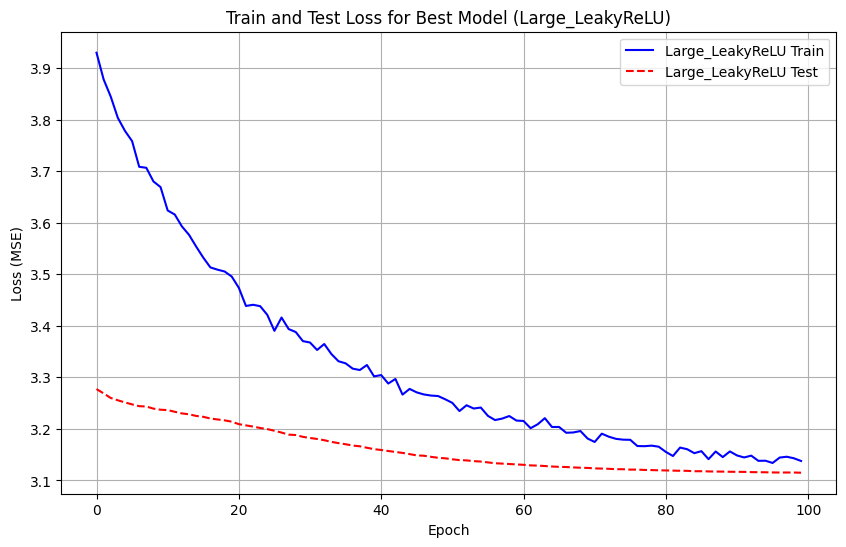

In [30]:
best_train_losses, best_test_losses = results[best_model_name]
plt.figure(figsize=(10, 6))
plt.plot(best_train_losses, label=f"{best_model_name} Train", color='blue')
plt.plot(best_test_losses, label=f"{best_model_name} Test", linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title(f'Train and Test Loss for Best Model ({best_model_name})')
plt.legend()
plt.grid(True)
plt.show()